# 12-Month LTV Case Study

This notebook implements a first iteration 12 month LTV prediction solution using the two provided files:
- `case_study_base.csv` (one row per customer)
- `case_study_xs.csv` (cross sell purchase events)

We follow the case study definition of value in the **first 12 months** after signup:
- Base value: monthly commission times the number of active months (capped at 12, cut short by churn)
- Plus one time commissions from cross sell purchases within the same window


## 0. Package Installation (Python 3.12.0)

We install all the relevant packages that we require for the project.

In [ ]:
%pip install -U numpy pandas matplotlib scikit-learn ipython

## 1. Setup

We import all the relevant libraries, fix random seeds for reproducibility, and define helper functions for parsing dates and counting active months.

In [20]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

SEED = 42
np.random.seed(SEED)


In [21]:
def parse_date(series: pd.Series, colname: str) -> pd.Series:
    out = pd.to_datetime(series, errors='coerce')
    if out.isna().all():
        raise ValueError(f"Column '{colname}' could not be parsed as datetime (all NaT).")
    return out

def month_diff_floor(start: pd.Timestamp, end: pd.Timestamp) -> int:
    """Full months between start and end, flooring partial months conservatively."""
    if pd.isna(start) or pd.isna(end) or end <= start:
        return 0
    months = (end.year - start.year) * 12 + (end.month - start.month)
    if end.day < start.day:
        months -= 1
    return max(0, months)

def rmse(y_true, y_pred) -> float:
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def regression_report(y_true, y_pred) -> dict:
    return {
        'rmse': rmse(y_true, y_pred),
        'mae': float(mean_absolute_error(y_true, y_pred)),
        'r2': float(r2_score(y_true, y_pred)),
    }


## 2. Load and validate data

We read both CSV files, validate required columns, parse dates, and run basic sanity checks (e.g., one row per customer in the base file).

In [22]:
from pathlib import Path

# File paths
BASE_PATH = Path.cwd().parent / "data" / "case_study_base.csv"
XS_PATH   = Path.cwd().parent / "data" / "case_study_xs.csv"


base = pd.read_csv(BASE_PATH)
xs = pd.read_csv(XS_PATH)

required_base = {
    'user_id','customer_started_at','customer_churned_at','product','commission','channel','age_bucket','operating_system'
}
required_xs = {'user_id','product','commission','date'}

missing_base = required_base - set(base.columns)
missing_xs = required_xs - set(xs.columns)
if missing_base:
    raise ValueError(f'Base is missing columns: {sorted(missing_base)}')
if missing_xs:
    raise ValueError(f'XS is missing columns: {sorted(missing_xs)}')

base['customer_started_at'] = parse_date(base['customer_started_at'], 'customer_started_at')
base['customer_churned_at'] = parse_date(base['customer_churned_at'], 'customer_churned_at')
xs['date'] = parse_date(xs['date'], 'date')

if base['user_id'].duplicated().any():
    raise ValueError('Expected one row per user in base, but found duplicates.')

missing_users = set(xs['user_id']) - set(base['user_id'])
if missing_users:
    raise ValueError('XS contains users not in base (unexpected).')

display(base.head())
display(xs.head())


,user_id,customer_started_at,customer_churned_at,product,commission,channel,age_bucket,operating_system
0,37d76d441d,2022-12-01,NaT,product_a,12.18,channel_a,55+,iOS
1,cdc1327d79,2024-05-09,NaT,product_a,12.46,channel_a,18-24,iOS
2,fac8c03aa8,2023-11-20,2025-01-01,product_c,21.66,channel_a,35-39,Android
3,b0c703a998,2022-05-21,NaT,product_a,12.05,channel_b,35-39,Android
4,0276bcc756,2023-04-15,NaT,product_c,15.77,channel_b,35-39,Android


,user_id,product,commission,date
0,ccc05d82e1,product_y,499.60,2024-08-05
1,77a488f223,product_y,821.30,2024-10-20
2,e717cb5a0b,product_y,1215.04,2025-01-19
3,1e9ca78b5b,product_y,413.18,2024-12-20
4,eee1f85c5c,product_y,354.45,2024-10-06


## 3. Target engineering: 12 month LTV

We compute the label exactly as in the case description:
- Active months in the first 12 months (cut short by churn)
- Base LTV = monthly commission * active months
- Cross sell LTV = sum of one time commissions for purchases within the same customer window
- Total LTV = base + cross sell

We use a conservative month counting rule: only fully completed months are counted.

In [23]:
df = base.copy()
df['horizon_end'] = df['customer_started_at'] + pd.DateOffset(months=12)
df['window_end'] = df['horizon_end']
churn_mask = df['customer_churned_at'].notna() & (df['customer_churned_at'] < df['horizon_end'])
df.loc[churn_mask, 'window_end'] = df.loc[churn_mask, 'customer_churned_at']

df['active_months_12m'] = df.apply(
    lambda r: min(12, month_diff_floor(r['customer_started_at'], r['window_end'])), axis=1
)
df['base_ltv_12m'] = df['commission'] * df['active_months_12m']

xs2 = xs.rename(columns={'commission':'xs_commission','product':'xs_product'}).copy()
xs2 = xs2.merge(df[['user_id','customer_started_at','window_end']], on='user_id', how='inner')
xs2 = xs2[(xs2['date'] >= xs2['customer_started_at']) & (xs2['date'] < xs2['window_end'])]

xs_ltv = xs2.groupby('user_id')['xs_commission'].sum().rename('xs_ltv_12m')
df = df.merge(xs_ltv, on='user_id', how='left')
df['xs_ltv_12m'] = df['xs_ltv_12m'].fillna(0.0)
df['ltv_12m'] = df['base_ltv_12m'] + df['xs_ltv_12m']

df['churned_within_12m'] = df['customer_churned_at'].notna() & (df['customer_churned_at'] < df['horizon_end'])
df['has_xs_within_12m'] = df['xs_ltv_12m'] > 0

df[['user_id','active_months_12m','base_ltv_12m','xs_ltv_12m','ltv_12m']].head()


,user_id,active_months_12m,base_ltv_12m,xs_ltv_12m,ltv_12m
0,37d76d441d,12,146.16,0.0,146.16
1,cdc1327d79,12,149.52,0.0,149.52
2,fac8c03aa8,12,259.92,0.0,259.92
3,b0c703a998,12,144.60,0.0,144.60
4,0276bcc756,12,189.24,0.0,189.24


## 4. Exploratory Data Analysis (EDA)

We inspect distributions and basic segment level metrics. The goal is to understand where value comes from, and which groups differ in churn or cross sell behavior.

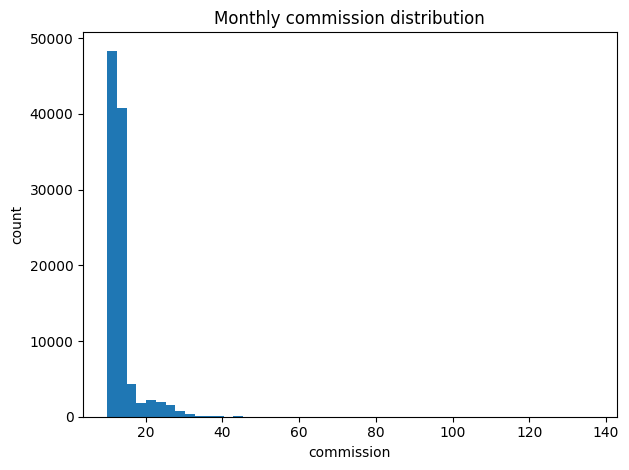

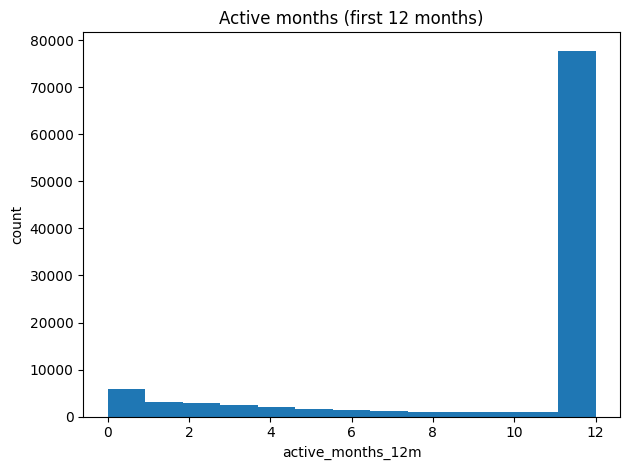

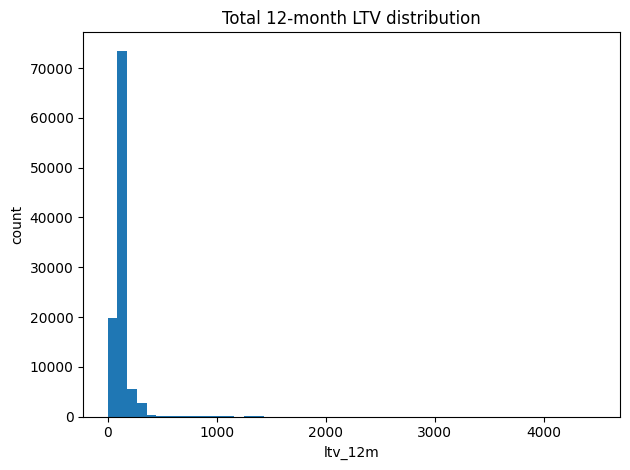

In [24]:
def plot_hist(series: pd.Series, title: str, bins: int = 50):
    plt.figure()
    plt.hist(series.dropna().values, bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel('count')
    plt.tight_layout()
    plt.show()

plot_hist(df['commission'], 'Monthly commission distribution')
plot_hist(df['active_months_12m'], 'Active months (first 12 months)', bins=13)
plot_hist(df['ltv_12m'], 'Total 12-month LTV distribution')


In [25]:
seg_cols = ['product','channel','age_bucket','operating_system']
segment_tables = {}
for col in seg_cols:
    seg = (df.groupby(col, dropna=False)
             .agg(n=('user_id','count'),
                  churn_rate=('churned_within_12m','mean'),
                  xs_rate=('has_xs_within_12m','mean'),
                  mean_ltv=('ltv_12m','mean'),
                  median_ltv=('ltv_12m','median'))
             .reset_index()
          )
    segment_tables[col] = seg
    display(seg.sort_values('mean_ltv', ascending=False))


,product,n,churn_rate,xs_rate,mean_ltv,median_ltv
2,product_c,15921,0.349915,0.007726,174.261372,159.96
1,product_b,4618,0.245561,0.004764,138.071403,157.20
0,product_a,82084,0.220762,0.004910,128.949187,145.08


,channel,n,churn_rate,xs_rate,mean_ltv,median_ltv
1,channel_b,56057,0.225610,0.006868,142.636375,146.28
0,channel_a,46566,0.261543,0.003500,128.869280,146.16


,age_bucket,n,churn_rate,xs_rate,mean_ltv,median_ltv
2,30-34,22731,0.223835,0.007083,140.697950,145.08
3,35-39,14100,0.270993,0.005035,138.867463,146.16
1,25-29,22346,0.210373,0.007787,138.799255,145.08
4,40-44,9266,0.293654,0.003885,134.820065,146.16
6,50-54,5810,0.235112,0.000516,133.943651,146.16
5,45-49,6298,0.278025,0.001270,132.828265,146.16
7,55+,11560,0.209429,0.000087,132.209807,146.16
0,18-24,10458,0.279308,0.008988,128.412805,145.08
8,undefined,54,0.666667,0.000000,65.841296,49.20


,operating_system,n,churn_rate,xs_rate,mean_ltv,median_ltv
2,iPadOS,797,0.095358,0.002509,145.042371,148.20
1,iOS,47520,0.190257,0.005997,143.168980,146.46
0,Android,48405,0.263774,0.005351,134.083485,145.08
4,NaN,5883,0.498385,0.000340,99.610807,120.00
3,iPhone OS,18,0.500000,0.000000,76.885000,100.00


## 5. Train/test split (time based)

To reduce leakage, we split by customer start date: the most recent cohorts go to the test set.

In [26]:
df = df.sort_values('customer_started_at').copy()
max_date = df['customer_started_at'].max()
cutoff = max_date - pd.DateOffset(months=6)
train = df[df['customer_started_at'] < cutoff].copy()
test = df[df['customer_started_at'] >= cutoff].copy()

# Fallback if split is too small
if len(train) < 1000 or len(test) < 500:
    train, test = train_test_split(df, test_size=0.2, random_state=SEED)

len(train), len(test), train['customer_started_at'].max(), test['customer_started_at'].min()


(90251,
 12372,
 Timestamp('2024-11-29 00:00:00'),
 Timestamp('2024-11-30 00:00:00'))

## 6. Modeling approach A: Direct Baseline Regression

This baseline predicts `ltv_12m` directly from signup features. It is simple and provides a reference point for performance.

In [27]:
def build_preprocessor(cat_cols, num_cols):
    cat_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])
    return ColumnTransformer(
        transformers=[('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)],
        remainder='drop'
    )


In [28]:
for d in (train, test):
    d['start_month'] = d['customer_started_at'].dt.month.astype(int)
    d['start_year'] = d['customer_started_at'].dt.year.astype(int)

cat_cols = ['product','channel','age_bucket','operating_system','start_month','start_year']
num_cols = ['commission']

X_train = train[cat_cols + num_cols]
y_train = train['ltv_12m'].values
X_test = test[cat_cols + num_cols]
y_test = test['ltv_12m'].values

pre = build_preprocessor(cat_cols, num_cols)
direct_model = Pipeline(steps=[('pre', pre), ('model', Ridge(random_state=SEED))])
direct_model.fit(X_train, y_train)
pred = direct_model.predict(X_test)

metrics_direct = regression_report(y_test, pred)
metrics_direct


{'rmse': 111.99859668807592,
 'mae': 51.82513977132675,
 'r2': 0.09962097832138517}

## 7. Modeling approach B: Decompose LTV

We model two components separately and then add them:
- Base value driven by churn (how long the customer stays active in the first 12 months)
- Cross sell value (probability of cross sell and expected one time commission)

### 7.1 Churn model as a discrete time hazard model

We build a person month dataset (up to 12 months). The model predicts the probability of churn in each month given the customer is still active.
From the monthly hazards we compute expected active months and expected base LTV.

In [29]:
def build_person_month_table(users_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in users_df.iterrows():
        active_m = int(r['active_months_12m'])
        churn_within = bool(r['churned_within_12m'])
        event_month = active_m + 1 if churn_within and active_m < 12 else None
        for m in range(1, 13):
            at_risk = active_m >= (m - 1)
            if not at_risk:
                break
            y = 1 if (event_month == m) else 0
            rows.append({
                'user_id': r['user_id'],
                'month': m,
                'event': y,
                'product': r['product'],
                'channel': r['channel'],
                'age_bucket': r['age_bucket'],
                'operating_system': r['operating_system'],
                'commission': r['commission'],
                'start_month': int(r['customer_started_at'].month),
                'start_year': int(r['customer_started_at'].year),
            })
            if y == 1:
                break
    return pd.DataFrame(rows)


In [30]:
pm_train = build_person_month_table(train)
pm_test = build_person_month_table(test)

cat_h = ['product','channel','age_bucket','operating_system','month','start_month','start_year']
num_h = ['commission']

X_tr = pm_train[cat_h + num_h]
y_tr = pm_train['event'].astype(int).values
X_te = pm_test[cat_h + num_h]
y_te = pm_test['event'].astype(int).values

haz_pre = build_preprocessor(cat_h, num_h)
haz_model = Pipeline(steps=[('pre', haz_pre), ('clf', LogisticRegression(max_iter=2000, random_state=SEED))])
haz_model.fit(X_tr, y_tr)

proba = haz_model.predict_proba(X_te)[:, 1]
auc_h = float('nan') if len(np.unique(y_te)) < 2 else float(roc_auc_score(y_te, proba))
auc_h


0.7859328221233428

In [31]:
def expected_active_months(users_df: pd.DataFrame, haz_model: Pipeline) -> np.ndarray:
    # predict hazard for each month 1..12, then compute survival and expected months
    pm_list = []
    for m in range(1, 13):
        tmp = users_df.copy()
        tmp['month'] = m
        tmp['start_month'] = tmp['customer_started_at'].dt.month.astype(int)
        tmp['start_year'] = tmp['customer_started_at'].dt.year.astype(int)
        pm_list.append(tmp)
    pm_all = pd.concat(pm_list, axis=0, ignore_index=True)
    h = haz_model.predict_proba(pm_all[cat_h + num_h])[:, 1].reshape(12, -1)
    S = np.cumprod(1.0 - h, axis=0)
    return S.sum(axis=0)

exp_m = expected_active_months(test, haz_model)
exp_base_ltv = exp_m * test['commission'].values
regression_report(test['base_ltv_12m'].values, exp_base_ltv)


{'rmse': 78.08512184162203,
 'mae': 51.286732737868896,
 'r2': -0.1392975598120969}

### 7.2 Cross sell model: probability + amount

We predict:
1) whether the customer will have any cross sell within 12 months
2) the expected cross-sell commission amount, conditional on having cross sell

Expected cross sell value is probability times conditional amount.

In [32]:
X_train = train[cat_cols + num_cols]
X_test = test[cat_cols + num_cols]
y_xs_train = train['has_xs_within_12m'].astype(int).values
y_xs_test = test['has_xs_within_12m'].astype(int).values

xs_pre = build_preprocessor(cat_cols, num_cols)
xs_cls = Pipeline(steps=[('pre', xs_pre), ('cls', LogisticRegression(max_iter=2000, random_state=SEED))])
xs_cls.fit(X_train, y_xs_train)
p_xs = xs_cls.predict_proba(X_test)[:, 1]
auc_xs = float('nan') if len(np.unique(y_xs_test)) < 2 else float(roc_auc_score(y_xs_test, p_xs))
auc_xs


0.6049594379450849

In [34]:
train_pos = train[train['has_xs_within_12m']].copy()
test_pos = test[test['has_xs_within_12m']].copy()

xs_reg = None
if len(train_pos) >= 50:
    xs_reg = Pipeline(steps=[('pre', xs_pre), ('reg', Ridge(random_state=SEED))])
    xs_reg.fit(train_pos[cat_cols + num_cols], train_pos['xs_ltv_12m'].values)
    cond_amount = np.clip(xs_reg.predict(X_test), 0.0, None)
else:
    cond_amount = np.full(len(test), float(train['xs_ltv_12m'].mean()))

exp_xs_value = p_xs * cond_amount
regression_report(test['xs_ltv_12m'].values, exp_xs_value)


{'rmse': 91.0801227199208,
 'mae': 12.984381574194787,
 'r2': -0.005080833650463523}

### 7.3 Combine into expected total LTV

Expected total 12 month LTV is expected base LTV plus expected cross-sell value.

In [35]:
exp_total = exp_base_ltv + exp_xs_value
metrics_decomposed = regression_report(test['ltv_12m'].values, exp_total)
metrics_decomposed


{'rmse': 122.60461413577178,
 'mae': 59.53365402679323,
 'r2': -0.07898109424174349}

## 8. Suggested next steps (future iterations)

Examples of improvements that typically help LTV work:
- Add richer behavioral and marketing features (campaign id, landing page, device details, etc.)
- Use better time to event models for churn (more features, calibrated probabilities)
- Model cross sell as a time to purchase process, not only a 12 month binary label
- Try tree based models for non-linearities (if allowed in your environment)
- Validate with cohort based monitoring and periodic retraining
